<a href="https://colab.research.google.com/github/sha7cs/tourists_route/blob/main/Tourists_Route.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# load data

In [ ]:
!pip install osmnx networkx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 1.3 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import pickle
import math
import pandas as pd
import geopy.distance
import random
import heapq
import numpy

this is the dataframe of Manhattan, NewYork tourist attraction places that we converted into a graph so we can  use it

In [ ]:
file_path = '/content/New.csv'
data = pd.read_csv(file_path)

data.head()

,ID,geometry,alt_name,ele,gnis:feature_id,name,name:ru,place,tourism,wikidata,...,name:bg,name:ml,seamark:platform:category,seamark:type,closed,tunnel,ways,addr:place,bicycle,old_railway_operator
0,1,POINT (-73.9795833 40.7251022),Loisaida,4.0,2062665.0,Alphabet City,Алфабет-сити,neighbourhood,yes,Q1156938,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,POINT (-73.9987505 40.72288),NaN,9.0,2045148.0,SoHo,Сохо,neighbourhood,attraction,Q461572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,POINT (-73.9713889 40.7486231),NaN,18.0,2083304.0,Tudor City,Тьюдор-сити,neighbourhood,yes,Q549206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,POINT (-74.0029056 40.7057505),NaN,NaN,NaN,South Street Seaport,NaN,NaN,attraction,Q223000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,POINT (-73.9972548 40.7322674),NaN,7.0,2080738.0,"New York Studio School of Drawing, Painting an...",NaN,NaN,yes,Q7014742,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Each node represents an attraction.
Nodes are labeled with the attraction's name.
Nodes contain attributes like the type of place and coordinates.
Here's how we'll set up the graph using NetworkX, and visualize it:

Download the graph from pickle file

In [ ]:
with open('graph.pkl', 'rb') as f:
    G = pickle.load(f)

filtering the nan values

## Data preprocessing

In [ ]:
G_copy = G.copy()

# Find nodes with nan values to avoid errors
nan_nodes = [node for node in G_copy.nodes() if isinstance(node, float) and math.isnan(node)]
G_copy.remove_nodes_from(nan_nodes)

the edges have no weight that will represnt the distance between the nodes, so here is a code that will calculate the distance based on the coordinates of the two nodes connected by an edge

In [ ]:
from geopy.distance import geodesic

for node1_name, node2_name in G_copy.edges:
    if 'coords' not in G_copy.nodes[node1_name] or 'coords' not in G_copy.nodes[node2_name]:
        continue

    node1_coords = G_copy.nodes[node1_name]['coords']
    node2_coords = G_copy.nodes[node2_name]['coords']

    distance_km = geodesic(node1_coords, node2_coords).kilometers

    # Assign the calculated distance as the weight of the edge
    G_copy.edges[node1_name, node2_name]['weight'] = round(distance_km, 2)

# Graph analyzing

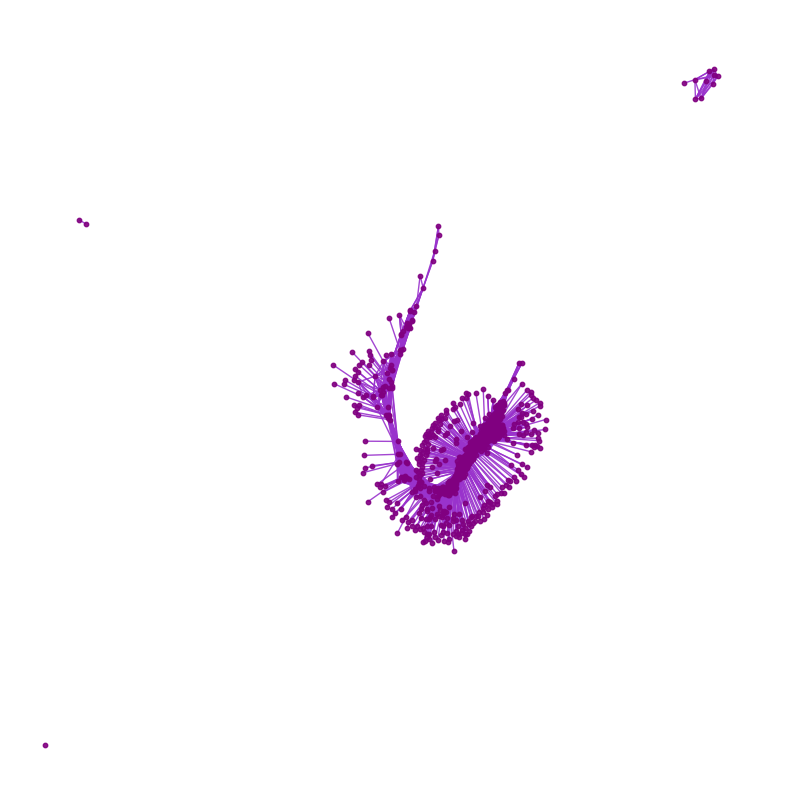

In [ ]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_copy)
nx.draw_networkx(
    G_copy,
    pos,
    with_labels=False,
    node_color='purple',
    node_size=10,
    edge_color='darkorchid',
    alpha=0.9,
)

plt.axis('off')
plt.show()

the number of edges for random node

In [ ]:
all_nodes = list(G_copy.nodes())

random_nodes = random.sample(all_nodes, k=10)

for node in random_nodes:
    degree = G_copy.degree(node)
    print("Node", node, "has", degree, "edges.")

Node 561042194 has 1 edges.
Node Center for Architecture has 253 edges.
Node International Center of Photography has 134 edges.
Node American Dream Bed & Breakfast has 158 edges.
Node 247081705 has 1 edges.
Node Broadway Mall Gallery has 62 edges.
Node Federal Reserve Bank of New York has 117 edges.
Node Deborah Bell Photographs has 180 edges.
Node 42439996 has 2 edges.
Node Andaz has 151 edges.


then here we will print 5 random edges weight

In [ ]:
all_edges = list(G_copy.edges(data=True))

random_edges = random.sample(all_edges, k=5)

for node1_name, node2_name, edge_data in random_edges:
    if 'weight' in edge_data:
        edge_weight = edge_data['weight']
        print(f"Weight of edge between '{node1_name}' and '{node2_name}': {edge_weight} km")
    else:
        print(f"No weight assigned to edge between '{node1_name}' and '{node2_name}'")

Weight of edge between 'Greenwich Village' and 'Anna Zorina Gallery': 0.55 km
Weight of edge between 'National Museum of Mathematics' and 'The Ride': 0.55 km
Weight of edge between 'The Fifth Avenue Hotel' and 'Harry Potter The Exhibition': 0.15 km
Weight of edge between '33 Seaport Hotel' and 'Audrey Hepburn': 0.64 km
Weight of edge between 'Jump into the Light VR Arcade' and 'The Delancey': 0.35 km


print the number of nodes and edges before and after filtering the nan values

In [ ]:
print(G)
print(G_copy)

Graph with 1058 nodes and 50670 edges
Graph with 1057 nodes and 50602 edges


the node (place) with the most traffic as in that people must likely would pass through that place

In [ ]:
betweenness_centrality = nx.betweenness_centrality(G_copy, weight='distance')
closeness_centrality = nx.closeness_centrality(G_copy, distance='distance')

max_betweenness_node = max(betweenness_centrality, key=betweenness_centrality.get)
max_betweenness_value = betweenness_centrality[max_betweenness_node]

max_closeness_node = max(closeness_centrality, key=closeness_centrality.get)
max_closeness_value = closeness_centrality[max_closeness_node]

print(f"Node with highest Betweenness Centrality: {max_betweenness_node} - {max_betweenness_value}")
print(f"Node with highest Closeness Centrality: {max_closeness_node} - {max_closeness_value}")


Node with highest Betweenness Centrality: CY GAVIN - 0.0731839036698866
Node with highest Closeness Centrality: Museum of Sex - 0.35075248140237925


shortest path between two nodes

In [ ]:
source_node = 'Alphabet City'
target_node = 'Red Panda'

shortest_path = nx.shortest_path(G, source=source_node, target=target_node)

print(f"The shortest path from {source_node} to {target_node} is:")
print(shortest_path)

The shortest path from Alphabet City to Red Panda is:
['Alphabet City', '70 Park Avenue Hotel', 'Red Panda']


shortest distance between two nodes

In [ ]:
try:
    shortest_path_length = nx.shortest_path_length(G, source_node, target_node, weight='distance')
    print(f"The shortest path distance between {source_node} and {target_node} is {shortest_path_length:.2f} km.")
except nx.NetworkXNoPath:
    print(f"There is no path between {source_node} and {target_node} in the graph.")

The shortest path distance between Alphabet City and Red Panda is 2.00 km.


nodes with most connectivity with other nodes

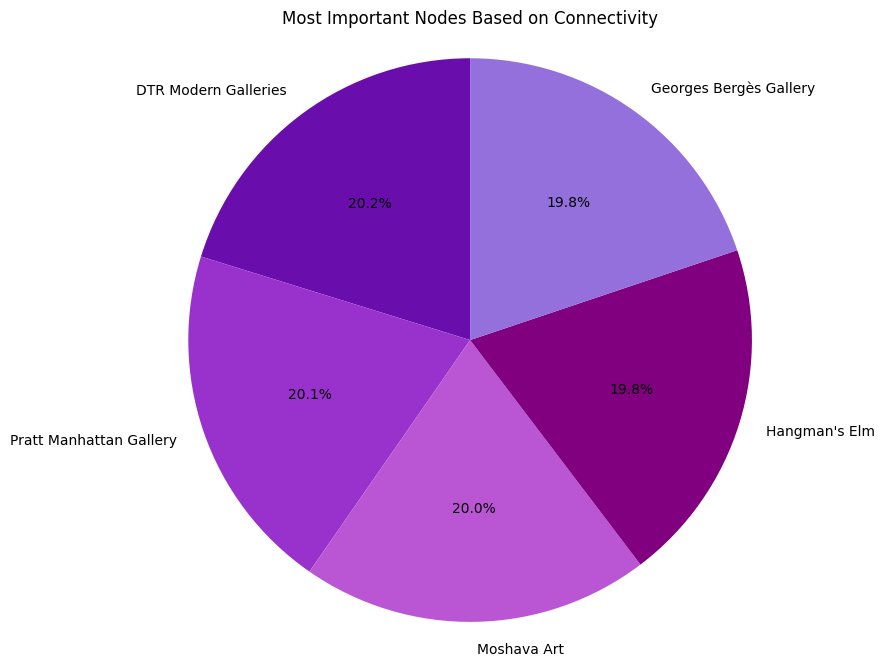

In [ ]:
degree_centrality = nx.degree_centrality(G_copy)
preferences = {node: val * 100 for node, val in degree_centrality.items()}

top_preferences = dict(sorted(preferences.items(), key=lambda item: item[1], reverse=True)[:5])

purple_shades = ['#6a0dad', '#9932cc', '#ba55d3', '#800080', '#9370db']

plt.figure(figsize=(8, 8))
plt.pie(top_preferences.values(), labels=top_preferences.keys(), autopct='%1.1f%%', startangle=90, colors=purple_shades)
plt.title('Most Important Nodes Based on Connectivity')
plt.axis('equal')
plt.show()

## Nearest Attractions

nearest attraction to a specific hotel

Suggested attractions near Hotel Belleclaire:
- Hotel Beacon (Distance: 0.05 km)
- The Wallace (Distance: 0.08 km)
- NYLO New York City (Distance: 0.08 km)
- Amsterdam Inn (Distance: 0.14 km)
- Hotel Churchill (Distance: 0.15 km)


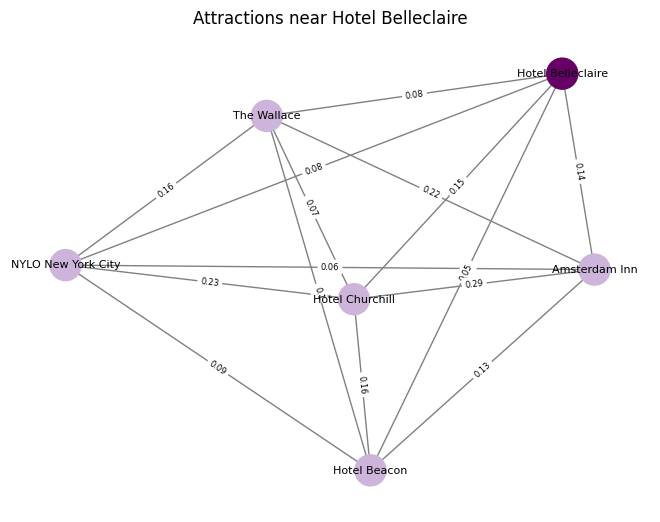

In [ ]:
hotel_name = 'Hotel Belleclaire'

hotel_coords = None
for node, node_data in G_copy.nodes(data=True):
    if node == hotel_name and 'coords' in node_data:
        hotel_coords = node_data['coords']
        break

if hotel_coords is None:
    print(f"No coordinates found for {hotel_name}.")
else:
    distances = []

    for neighbor, edge_data in G_copy[hotel_name].items():
        if 'weight' in edge_data:
            distance = edge_data['weight']
            distances.append((distance, neighbor))

    nearest_attractions = heapq.nsmallest(5, distances, key=lambda x: x[0])

    print(f"Suggested attractions near {hotel_name}:")
    for distance, attraction in nearest_attractions:
        print(f"- {attraction} (Distance: {distance:.2f} km)")

    subgraph_nodes = [hotel_name] + [attraction for distance, attraction in nearest_attractions]
    subgraph = G_copy.subgraph(subgraph_nodes)

    pos = nx.spring_layout(subgraph, seed=42)

    node_colors = ['#660066' if node == hotel_name else '#CDB4DB' for node in subgraph.nodes()]

    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=8, edge_color='gray')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=nx.get_edge_attributes(subgraph, 'weight'), font_size=6)

    plt.title(f"Attractions near {hotel_name}")
    plt.show()

# calculating the shortest path

a specific nodes to test and compare the algorithms on

In [ ]:
specific_nodes = ['Soho Grand Hotel', 'The Real World', 'Residence Inn', 'The Beekman, A Thompson Hotel']

for plotting paths

In [ ]:
def plot_path(G, path,title):
    if not path:
        print("No path to display.")
        return

    plt.figure(figsize=(12, 8))

    colors = ['#4B0082', '#68228B', '#7F4E98', '#976AA5', '#AF86B2', '#CDB4DB', '#E6D6ED', '#F7F0FF']

    edges_in_path = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
    nodes_in_path = set(path)
    H = G.subgraph(nodes_in_path).edge_subgraph(edges_in_path).copy()
    pos = nx.spring_layout(H)

    nx.draw_networkx_nodes(H, pos, node_color='mediumorchid', node_size=700)

    for i, edge in enumerate(edges_in_path):
        nx.draw_networkx_edges(H, pos, edgelist=[edge], width=2, alpha=0.6,
                               edge_color=[colors[i]], arrows=True, arrowsize=20,
                               arrowstyle='-|>', connectionstyle='arc3,rad=0.1')

    nx.draw_networkx_labels(H, pos, font_size=12, font_color='darkblue')


    edge_labels = {(u, v): G[u][v]['weight'] for u, v in edges_in_path if 'weight' in G[u][v]}
    nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, label_pos=0.5, font_color='black')

    plt.title(title)
    plt.axis('off')
    plt.show()

## Dijkstra's Algorithm

In [ ]:
def find_path(graph, nodes):
    total_path = []
    total_distance = 0
    for i in range(len(nodes) - 1):
        path = nx.dijkstra_path(graph, source=nodes[i], target=nodes[i+1])
        path_distance = nx.dijkstra_path_length(graph, source=nodes[i], target=nodes[i+1])
        total_path.extend(path[:-1])
        total_distance += path_distance
    total_path.append(nodes[-1])

    return total_path, total_distance

Selected nodes: ['Soho Grand Hotel', 'The Real World', 'Residence Inn', 'The Beekman, A Thompson Hotel']
The minimum cost tour is: ['Soho Grand Hotel', 'Jackie Robinson Museum', 'The Real World', 'Residence Inn', 'The Beekman, A Thompson Hotel']
With a total cost of: 2.27


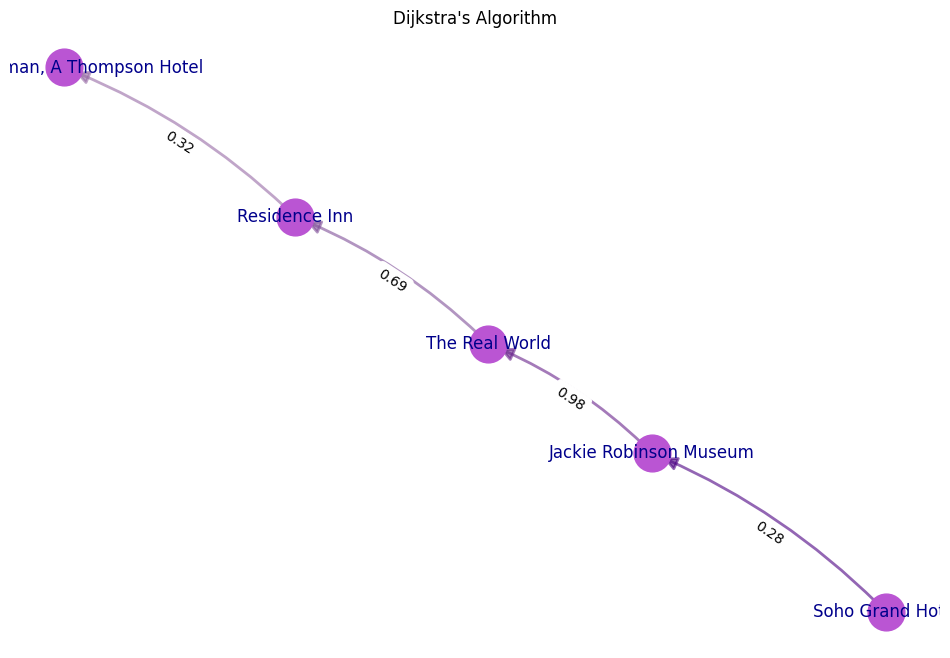

In [ ]:
tour_path, tour_distance = find_path(G_copy, specific_nodes)

print("Selected nodes:", specific_nodes)
print("The minimum cost tour is:", tour_path)
print("With a total cost of:", tour_distance)
plot_path(G_copy, tour_path,'Dijkstra\'s Algorithm')

## salesman

In [ ]:
def tour_cost(G, tour):
    if len(tour) < 2:
        print("Warning: Tour has fewer than two nodes.")
        return 0

    tour = list(tour)
    total_cost = 0
    complete_path = []

    for i in range(len(tour)):
        u = tour[i]
        v = tour[(i + 1) % len(tour)] if i < len(tour) - 1 else None

        if u == v:
            continue

        if v and G.has_edge(u, v):
            weight = G[u][v].get('weight', 1)
            total_cost += weight
            complete_path.append(u)
        elif v:
            path = nx.shortest_path(G, source=u, target=v, weight='weight')
            path_cost = nx.shortest_path_length(G, source=u, target=v, weight='weight')
            total_cost += path_cost
            complete_path.extend(path[:-1])

    if tour:
        complete_path.append(tour[-1])

    return total_cost, complete_path


In [ ]:
from itertools import permutations
def sales_man(G, nodes):
    if len(nodes) < 2:
        print("Error: Not enough nodes to form a tour.")
        return None, 0

    min_tour = None
    min_cost = float('inf')
    min_path = []

    for perm in permutations(nodes):
        cost, path = tour_cost(G, perm)
        if cost < min_cost:
            min_cost = cost
            min_tour = perm
            min_path = path

    return min_tour, min_cost, min_path

Selected nodes: ['Soho Grand Hotel', 'The Real World', 'Residence Inn', 'The Beekman, A Thompson Hotel']
The minimum cost tour is: ('Soho Grand Hotel', 'The Beekman, A Thompson Hotel', 'Residence Inn', 'The Real World')
The full path is: ['Soho Grand Hotel', 'The Beekman, A Thompson Hotel', 'Residence Inn', 'The Real World']
With a total cost of: 1.45


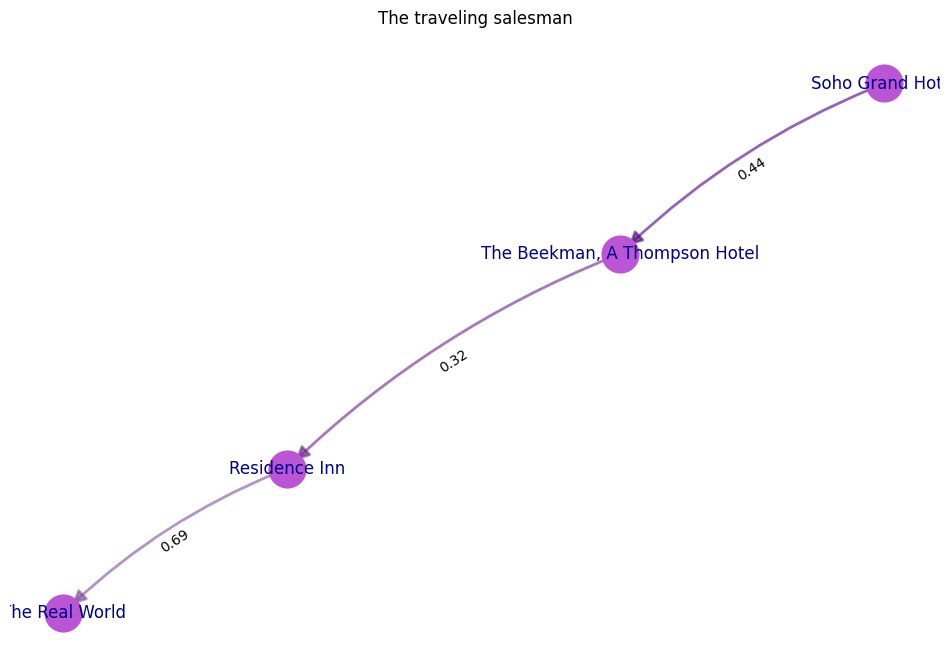

In [ ]:
sm_tour, sm_cost, sm_path = sales_man(G_copy, specific_nodes)

print("Selected nodes:", specific_nodes)
print("The minimum cost tour is:", sm_tour)
print("The full path is:", sm_path)
print("With a total cost of:", sm_cost)

plot_path(G_copy, sm_path,'The traveling salesman')

## A* algorithm

In [ ]:
def heuristic(a, b):
    """
    Calculates the geodesic distance between two coordinates.
    """
    return geodesic(a, b).kilometers

def a_star_path_length(graph, start, goal):
    """
    Implements the A* algorithm to find the shortest path and its length from start to goal.
    """
    pq = [(0, start, [])]
    visited = set()

    while pq:
        (cost, current, path) = heapq.heappop(pq)

        if current in visited:
            continue
        visited.add(current)

        new_path = path + [current]

        if current == goal:
            return new_path, cost

        for neighbor in graph.neighbors(current):
            if neighbor not in visited:
                if 'coords' in graph.nodes[current] and 'coords' in graph.nodes[neighbor]:
                    estimated_cost = cost + graph[current][neighbor]['weight']
                    heuristic_cost = heuristic(graph.nodes[current]['coords'], graph.nodes[goal]['coords'])
                    total_cost = estimated_cost + heuristic_cost
                    heapq.heappush(pq, (total_cost, neighbor, new_path))

    return None, float('inf')

def find_path2(graph, nodes):
    total_path = []
    total_distance = 0
    for i in range(len(nodes) - 1):
        path, path_distance = a_star_path_length(graph, nodes[i], nodes[i+1])
        total_path.extend(path[:-1])
        total_distance += path_distance
    total_path.append(nodes[-1])

    return total_path, total_distance

Selected nodes: ['Soho Grand Hotel', 'The Real World', 'Residence Inn', 'The Beekman, A Thompson Hotel']
The minimum cost tour is: ['Soho Grand Hotel', 'Icarus', 'The Real World', 'Residence Inn', 'The Beekman, A Thompson Hotel']
With a total cost of: 4.962012040629408


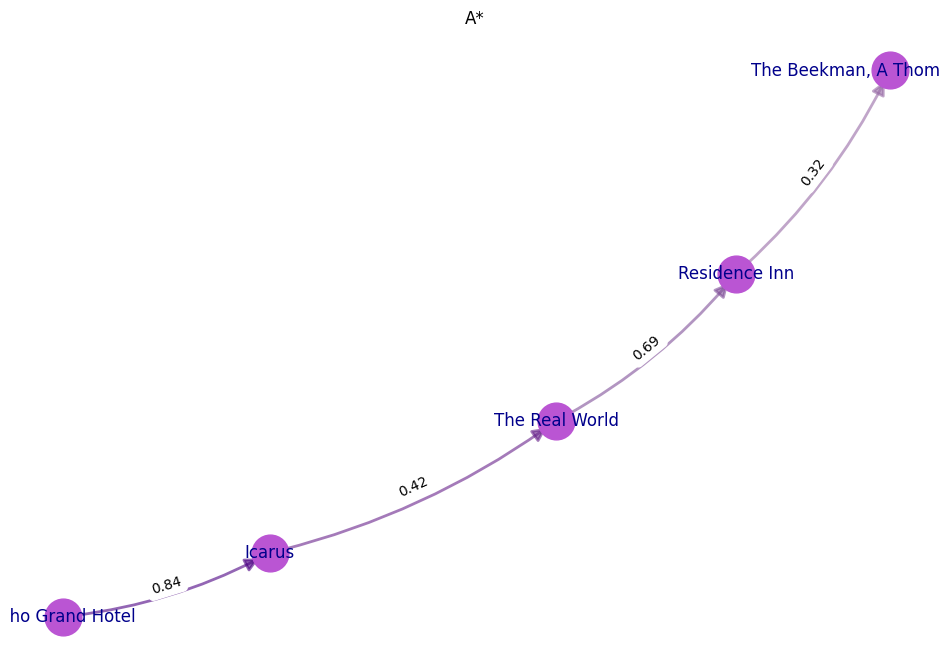

In [ ]:
tour_path, tour_distance = find_path2(G_copy, specific_nodes)


print("Selected nodes:", specific_nodes)
print("The minimum cost tour is:", list(tour_path))
print("With a total cost of:", tour_distance)
plot_path(G_copy, tour_path,'A*')


## algorithms comaprsion

Distance comparsion

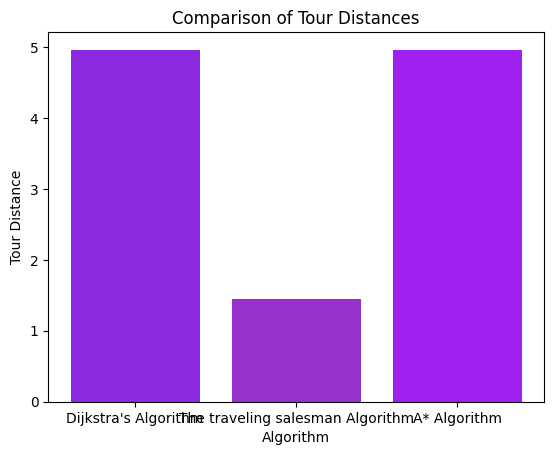

In [ ]:
tour_distances = []
tour_distances.append(tour_distance)
tour_distances.append(sm_cost)
tour_distances.append(tour_distance)

labels = ['Dijkstra\'s Algorithm', 'The traveling salesman Algorithm', 'A* Algorithm']

colors = ['#8A2BE2', '#9932CC', '#A020F0']
plt.bar(labels, tour_distances,color=colors)
plt.xlabel('Algorithm')
plt.ylabel('Tour Distance')
plt.title('Comparison of Tour Distances')
plt.show()

Memory Usage comparsion

In [ ]:
pip install memory_profiler

In [ ]:
from memory_profiler import memory_usage

def execute_dijkstra(graph, nodes):
    return find_path(graph, nodes)

def execute_salesman(graph, nodes):
    return sales_man(graph, nodes)

def execute_a_star(graph, nodes):
    return find_path2(graph, nodes)

mem_usage_dijkstra = memory_usage((execute_dijkstra, (G_copy, specific_nodes)), max_usage=True)
mem_usage_salesman = memory_usage((execute_salesman, (G_copy, specific_nodes)), max_usage=True)
mem_usage_a_star = memory_usage((execute_a_star, (G_copy, specific_nodes)), max_usage=True)

print("Memory usage for Dijkstra's Algorithm:", mem_usage_dijkstra, "MB")
print("Memory usage for Traveling Salesman:", mem_usage_salesman, "MB")
print("Memory usage for A* Algorithm:", mem_usage_a_star, "MB")


Memory usage for Dijkstra's Algorithm: 297.70703125 MB
Memory usage for Traveling Salesman: 297.70703125 MB
Memory usage for A* Algorithm: 297.70703125 MB


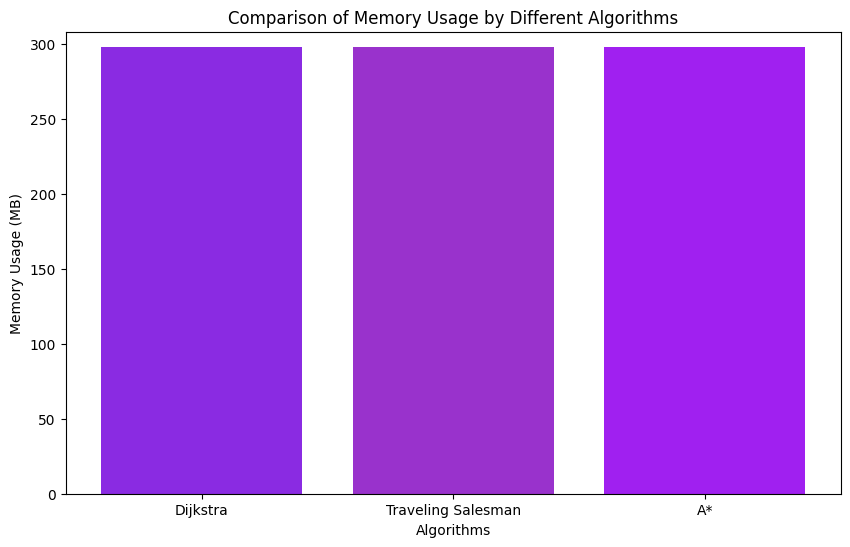

In [ ]:
mem_usage_dijkstra = memory_usage((execute_dijkstra, (G_copy, specific_nodes)), max_usage=True)
mem_usage_salesman = memory_usage((execute_salesman, (G_copy, specific_nodes)), max_usage=True)
mem_usage_a_star = memory_usage((execute_a_star, (G_copy, specific_nodes)), max_usage=True)

memory_usage_data = [mem_usage_dijkstra, mem_usage_salesman, mem_usage_a_star]
algorithms = ['Dijkstra', 'Traveling Salesman', 'A*']

plt.figure(figsize=(10, 6))

colors = ['#8A2BE2', '#9932CC', '#A020F0']
plt.bar(algorithms, memory_usage_data, color=colors)
plt.xlabel('Algorithms')
plt.ylabel('Memory Usage (MB)')
plt.title('Comparison of Memory Usage by Different Algorithms')
plt.ylim(0, max(memory_usage_data) + 10)

plt.show()

runtime performance comparsion

In [ ]:
import timeit
num_iterations = 500

find_path_time = timeit.timeit(lambda: find_path(G_copy, specific_nodes), number=num_iterations)
sales_man_time = timeit.timeit(lambda: sales_man(G_copy, specific_nodes), number=num_iterations)
A_star_time = timeit.timeit(lambda: (tour_path, tour_distance := find_path(G_copy, specific_nodes))[0], number=num_iterations)

print("Algorithm 1 - Dijkstra's:")
print("Runtime:", find_path_time/num_iterations)

print("\nAlgorithm 2 - The traveling salesman:")
print("Runtime:", sales_man_time/num_iterations)

print("\nAlgorithm 3 - A*:")
print("Runtime:", find_path_time / num_iterations)

Algorithm 1 - Dijkstra's:
Runtime: 0.10116837041199994

Algorithm 2 - The traveling salesman:
Runtime: 0.514421410448

Algorithm 3 - A*:
Runtime: 0.10116837041199994


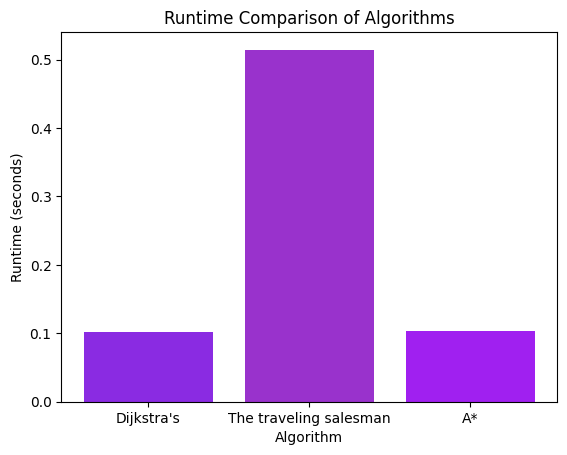

In [ ]:
algorithms = ['Dijkstra\'s', 'The traveling salesman', 'A*']
runtimes = [find_path_time / num_iterations, sales_man_time / num_iterations, A_star_time / num_iterations]

colors = ['#8A2BE2', '#9932CC', '#A020F0']
plt.bar(algorithms, runtimes,color=colors)
plt.xlabel('Algorithm')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime Comparison of Algorithms')
plt.show()